In [ ]:
# This script is designed to train a regression model to prediction the mRALE based pneumonia severetiy based on chest X-ray images (CXR) using the Hugging Face Transformers library.
# This notebook is for demonstration purposes and may require additional modifications to run in your environment. 
# If you want to replicate the experiment, please contact the author.


import os
import torch
from torch import nn
from transformers import AutoModel, AutoImageProcessor
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset
from datasets import Dataset, load_dataset, DatasetDict
import torch.nn as nn
from transformers import SegformerForImageClassification, AutoModelForImageClassification
from transformers import TrainingArguments, Trainer
# from transformers import ResNetForImageClassification, Trainer, TrainingArguments, AutoImageProcessor,CvtModel,SegformerForImageClassification
# from transformers import MobileViTFeatureExtractor, MobileViTForImageClassification, AutoImageProcessor
# from transformers import AutoFeatureExtractor, ViTForImageClassification, ConvNextForImageClassification, ConvNextImageProcessor
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import shutil
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# search and delete all the .ipynb_checkpoints folders
base_folder = "/root/GAN_models/covid_cv"

# Walk through the directory
for root, dirs, _ in os.walk(base_folder):
    for dir_name in dirs:
        if dir_name == ".ipynb_checkpoints":
            folder_path = os.path.join(root, dir_name)
            try:
                shutil.rmtree(folder_path)  # Delete the folder
                print(f"Deleted folder: {folder_path}")
            except Exception as e:
                print(f"Error deleting folder {folder_path}: {e}")

In [ ]:
def get_png_files(img_dir):
    png_files = []
    for subdir, _, files in os.walk(img_dir):
        for file in files:
            if file.endswith('.png'):
                # Get the absolute path and add it to the list
                png_files.append(os.path.abspath(os.path.join(subdir, file)))
    return png_files

In [ ]:
# data = pd.read_csv('/root/GAN_models/covid_cv/regression_fold/all_stats_empty.csv')
# data['whole_path'] = ""
# data['crop_path'] = ""
wholefile_paths = '/root/GAN_models/covid_cv/fold1'
cropfile_paths = '/root/GAN_models/covid_cv/crop_fold1'

# images = get_png_files(wholefile_paths)
# crop_images = get_png_files(cropfile_paths)
# data.to_csv('/root/GAN_models/covid_cv/regression_fold/file_list.csv')

# for file in images:
#     basename = os.path.basename(file)
#     row = data[data['filename'] == basename]
#     if row.empty:
#         print(f'cannot find: {file}')
#         continue
#     else:
#         idx = row.index[0]
#         data.at[idx, 'whole_path'] = file
# # data.to_csv('/root/GAN_models/covid_cv/regression_fold/file_list.csv')


# for file in crop_images:
#     basename = os.path.basename(file)
#     row = data[data['filename'] == basename]
#     if row.empty:
#         print(f'cannot find: {file}')
#         continue
#     else:
#         idx = row.index[0]
#         data.at[idx, 'crop_path'] = file

# data.to_csv('/root/GAN_models/covid_cv/regression_fold/file_list.csv')

In [6]:
# model_name = "apple/mobilevit-small"
model_name = "facebook/dinov2-base"
# model_name = "nvidia/mit-b0"
# model_name = "facebook/convnextv2-tiny-1k-224"

image_processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=1)

# Modify the classifier layer to output a single continuous value for regression
# model.classifier = nn.Linear(model.classifier.in_features, 1)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
data = pd.read_csv('/root/GAN_models/covid_cv/regression_fold/file_list.csv')
# data['mRALE_Score'] = pd.to_numeric(data['mRALE_Score'], errors='coerce')
train_data = data[data['fold'] != 5]
val_data = data[data['fold'] == 5]

print(train_data.shape, val_data.shape)

(698, 26) (171, 26)


In [8]:
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

In [9]:
def preprocess_data(examples):
    image = Image.open(examples["crop_path"]).convert("RGB")
    inputs = image_processor(image, return_tensors="pt")
    inputs["label"] = torch.tensor(float(examples["mRALE_Score"])).unsqueeze(-1)  # Reshape to [1]
    return {
        "pixel_values": inputs["pixel_values"][0],
        "label": inputs["label"]
    }

In [10]:
train_dataset = train_dataset.map(preprocess_data)
val_dataset = val_dataset.map(preprocess_data)

Map: 100%|██████████| 171/171 [00:03<00:00, 43.42 examples/s]


In [11]:
# Load the pretrained ConvNeXt V2 model
# model = SegformerForImageClassification.from_pretrained(model_name)


In [11]:
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def compute_metrics(p):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds)
    labels = p.label_ids
    loss = mean_squared_error(labels, preds)
    mse = loss
    mae = mean_absolute_error(labels, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(labels, preds)
    return {"loss": loss, "mse": mse, "mae": mae, "rmse": rmse, "r2": r2}

In [12]:
# Define training arguments

training_args = TrainingArguments(
    output_dir="/root/GAN_models/covid_cv/regression_fold/dinov2_fold5",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    weight_decay=0.02,
    save_total_limit=2,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=60,
    logging_dir='/root/GAN_models/covid_cv/regression_fold/logs',
    logging_steps=10,
    metric_for_best_model = 'mse',
    load_best_model_at_end=True,
)

In [13]:
# Define and run the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=None,
)

In [14]:
#flash gpu memory

torch.cuda.empty_cache()

In [15]:
# Train and evaluate
train_results = trainer.train()
trainer.save_model("/root/GAN_models/covid_cv/regression_fold/dinov2_fold5/dinov2_fold5_model")

trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Mse,Mae,Rmse,R2
1,79.111400,58.364727,58.364727,6.787222,7.639681,0.084076
2,60.037600,49.168865,49.168865,5.603004,7.012052,0.228388
3,55.792700,55.798336,55.798336,6.440962,7.469829,0.124351
4,51.293000,52.782890,52.782890,5.825072,7.265183,0.171672
5,56.484700,46.920631,46.920631,5.231240,6.849864,0.263669
6,52.641800,47.525463,47.525463,5.453811,6.893871,0.254178
7,49.223400,78.564796,78.564796,7.795741,8.863679,-0.232926
8,60.569000,49.706116,49.706116,5.983597,7.050256,0.219957
9,52.786000,40.060593,40.060593,4.978102,6.329344,0.371325
10,42.828300,42.459877,42.459877,5.032225,6.516124,0.333673


***** train metrics *****
  epoch                    =         60.0
  total_flos               = 3050022503GF
  train_loss               =      23.0651
  train_runtime            =   1:56:52.01
  train_samples_per_second =        5.973
  train_steps_per_second   =        0.094


In [16]:
def plot_metrics_with_labels(log_dict, title="Training and Validation Metrics", save_path=None):
    """
    Plots training and validation metrics including eval_acc, and adds a label with the final scores.

    Args:
        log_dict (list): List of log entries containing training and evaluation metrics.
        title (str): Title of the plot.
        save_path (str): File path to save the plot (e.g., 'metrics_plot.png').
    """
    # Extract metrics from log_dict
    train_losses = [entry['loss'] for entry in log_dict if 'loss' in entry]
    eval_losses = [entry['eval_loss'] for entry in log_dict if 'eval_loss' in entry]
    # auc_scores = [entry['eval_auc'] for entry in log_dict if 'eval_auc' in entry]
    mae_scores = [entry['eval_mae'] for entry in log_dict if 'eval_mae' in entry]
    rmse_scores = [entry['eval_rmse'] for entry in log_dict if 'eval_rmse' in entry]
    r_squared_scores = [entry['eval_r2'] for entry in log_dict if 'eval_r2' in entry]

    # Get the final metrics
    final_mse = eval_losses[-1]
    # final_auc = auc_scores[-1]
    final_mae = mae_scores[-1]
    final_rmse = rmse_scores[-1]
    final_r2 = r_squared_scores[-1]

    # Set Seaborn style
    sns.set(style="whitegrid", palette="muted", font_scale=1.2)

    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Training and Validation Loss
    sns.lineplot(x=range(len(train_losses)), y=train_losses, label="Train Loss", marker='o', linestyle='-')
    sns.lineplot(x=range(len(eval_losses)), y=eval_losses, label="Val Loss", marker='x', linestyle='--')

    # AUC Score
    # sns.lineplot(x=range(len(auc_scores)), y=auc_scores, label="Validation AUC", marker='s', linestyle='-.')

    # F1 Score
    # sns.lineplot(x=range(len(f1_scores)), y=f1_scores, label="Validation F1 Score", marker='d', linestyle=':')

    # Accuracy Score
    # sns.lineplot(x=range(len(acc_scores)), y=acc_scores, label="Validation Accuracy", marker='^', linestyle='-')

    # Add labels and title
    plt.xlabel("training Epochs", fontsize=12)
    plt.ylabel("Loss Value", fontsize=12)
    plt.title(title, fontsize=18)

    # Add legend with final metrics
    # final_label = f"Acc:{final_acc:.3f}, AUC:{final_auc:.3f}, F1:{final_f1:.3f}"
    final_label = f"MSE:{final_mse:.2f}, MAE:{final_mae:.2f}, RMSE:{final_rmse:.2f}, R-squared:{final_r2:.2f}"
    plt.legend(title=final_label, fontsize=12, title_fontsize=10, loc="best", handlelength=3, handleheight=2)

    # Add gridlines
    plt.grid(visible=True, linestyle="--", alpha=0.7)

    # Save the plot if a save_path is provided
    if save_path:
        plt.savefig(save_path, format="png", dpi=300, bbox_inches="tight")
        print(f"Plot saved to {save_path}")

    # Show the plot
    plt.show()

Plot saved to /root/GAN_models/covid_cv/regression_fold/dinov2_fold5/training_metrics.png


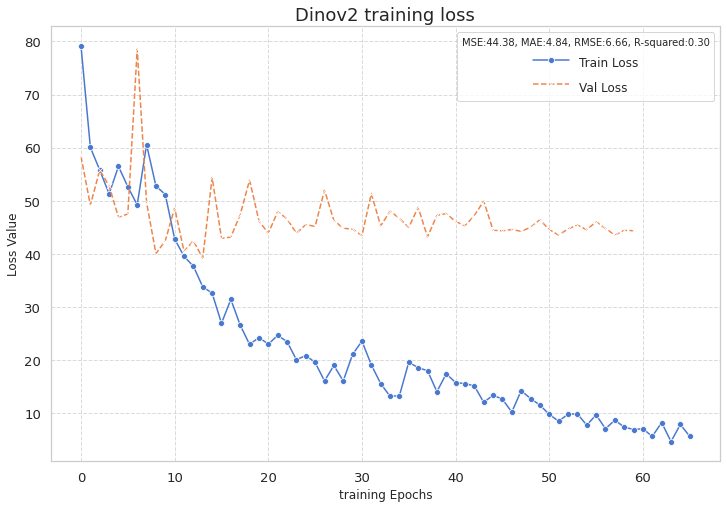

In [17]:
# Extract log history
log_history = trainer.state.log_history
png_path = "/root/GAN_models/covid_cv/regression_fold/dinov2_fold5/training_metrics.png"

plot_metrics_with_labels(log_history, "Dinov2 training loss", png_path)

In [18]:
import json

dest_path = "/root/GAN_models/covid_cv/regression_fold/dinov2_fold5/train_log_history.json"
# Save log_history to a JSON file
with open(dest_path, "w") as f:
    json.dump(log_history, f, indent=4)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = "facebook/dinov2-base"
checkpoint_dir = '/root/GAN_models/covid_cv/regression_fold/dinov2_fold5/dinov2_fold5_model'
feature_extractor = AutoImageProcessor.from_pretrained(model_name)
regressor = AutoModelForImageClassification.from_pretrained(checkpoint_dir, num_labels=1)

In [20]:
regressor.to(device)
regressor.eval()
print("model loaded to GPU")

model loaded to GPU


In [21]:
import torch.nn.functional as F

def preprocess_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = image.resize((224, 224))
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs

def predict_mRALE(image_path, model):
    inputs = preprocess_image(image_path)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    # Make predictions
    with torch.no_grad():
        outputs = model.model(**inputs)
    # Get the predicted class
    logits = outputs.logits
    pred_score = logits.item()
    if pred_score < 0:
        pred_score = 0
        return round(pred_score, 2)
    else:
        return round(pred_score, 2)

In [22]:
def predict_score(image_path, model):
    inputs = preprocess_image(image_path)
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = regressor(**inputs)
    score = outputs.logits.item()
    if score < 0:
        score = 0
    return round(score, 2)

In [23]:
data_file = pd.read_csv('/root/GAN_models/covid_cv/regression_fold/file_list.csv')
# data['mRALE_Score'] = pd.to_numeric(data['mRALE_Score'], errors='coerce')
val_data = data_file[data_file['fold'] == 5]

In [24]:
val_images = val_data['crop_path'].tolist()
img_path = val_images[10]
print(img_path)

/root/GAN_models/covid_cv/crop_fold1/train/positive/chest_XR_486.png


In [25]:
pred_score_1 = predict_score(img_path, regressor)
print(pred_score_1)

12.15


In [26]:
pred_score_2 = predict_mRALE(img_path, trainer)
print(pred_score_2)

12.15


In [27]:
data = pd.read_csv('/root/GAN_models/covid_cv/regression_fold/regression_val.csv')

for image_path in val_images:
    image_name = os.path.basename(image_path)
    row_index = data.index[data['filename'] == image_name].tolist()
    if len(row_index) > 1:
        print("more than one image is identified.")
    idx = row_index[0]

    if not row_index:
        print(f"Image {image_name} cannot be found in the dataset.")
        continue
        
    pred_score_1 = predict_score(image_path, regressor)
    data.loc[idx, 'load_dinov2'] = pred_score_1
    # pred_score_2 = predict_score(image_path, regressor)
    pred_score_2 = predict_mRALE(image_path, trainer)
    data.loc[idx, 'dinov2'] = pred_score_2
    print(f"regressor: {pred_score_1}, trainer: {pred_score_2}")
    
data.to_csv('/root/GAN_models/covid_cv/regression_fold/regression_val.csv', index=False)
print("predictions saved.")

regressor: 10.16, trainer: 10.16
regressor: 10.01, trainer: 10.01
regressor: 11.31, trainer: 11.31
regressor: 14.91, trainer: 14.91
regressor: 14.95, trainer: 14.95
regressor: 12.43, trainer: 12.43
regressor: 8.95, trainer: 8.95
regressor: 12.75, trainer: 12.75
regressor: 15.8, trainer: 15.8
regressor: 11.87, trainer: 11.87
regressor: 12.15, trainer: 12.15
regressor: 11.89, trainer: 11.89
regressor: 11.58, trainer: 11.58
regressor: 13.34, trainer: 13.34
regressor: 15.29, trainer: 15.29
regressor: 10.83, trainer: 10.83
regressor: 15.33, trainer: 15.33
regressor: 16.59, trainer: 16.59
regressor: 10.61, trainer: 10.61
regressor: 13.91, trainer: 13.91
regressor: 11.03, trainer: 11.03
regressor: 13.65, trainer: 13.65
regressor: 12.47, trainer: 12.47
regressor: 10.83, trainer: 10.83
regressor: 14.86, trainer: 14.86
regressor: 11.79, trainer: 11.79
regressor: 8.52, trainer: 8.52
regressor: 15.89, trainer: 15.89
regressor: 16.58, trainer: 16.58
regressor: 14.93, trainer: 14.93
regressor: 16.01